In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from collections import defaultdict
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests

from scipy.stats import shapiro, levene, rankdata, linregress, kruskal

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import helper

/gpfs1/home/c/p/cpetak/CA_GRN2/helper.py:164: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = windows.dot(grn)
/gpfs1/home/c/p/cpetak/CA_GRN2/helper.py:185: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = gene_vals.dot(internal_grn)


In [121]:
root1="~/scratch/non_detailed_save/extra_inputs/"
root2="~/scratch/non_detailed_save/"
root3="~/scratch/detailed_save/"
season_len = 300
seed_intss = [[69904,149796],[4147842,1238860],[1677032,1410667],[2607162,1754028],[286634,159689],[2961036,153075],[3430997,2634107]]
metric = "avefits"
num_reps = 15

avexs = []
aveys = []
rules = [22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102]

print(len(rules))


data = []
ave_pss=[]
for idx, seed_ints in enumerate(seed_intss):
    for rule in rules:
        if idx == 0:
            root=root3
        elif idx == 1:
            root=root2
        else:
            root=root1
        vari_maxs, env1_maxs, env2_maxs=helper.get_fits([rule,rule], seed_ints, metric, root, season_len, num_reps, id_start = 0)
        vari_maxs=[v[:9600] for v in vari_maxs]
        env1_maxs=[v[:9600] for v in env1_maxs]
        env2_maxs=[v[:9600] for v in env2_maxs]
        if metric == "geno_stds":
            vari_maxs=[v[9000:] for v in vari_maxs]
            env1_maxs=[v[9000:] for v in env1_maxs]
            env2_maxs=[v[9000:] for v in env2_maxs]
        d,c,ps,lists = helper.scatter_value(vari_maxs, env1_maxs, env2_maxs, season_len=300)
        for i in range(num_reps): #list1, list2, static1, static2
            data.append({'CA': str(rule), 'Seed': str(seed_ints), 'Env': "vari1", 'Val': lists[0][i]})
            data.append({'CA': str(rule), 'Seed': str(seed_ints), 'Env': "vari2", 'Val': lists[1][i]})
            data.append({'CA': str(rule), 'Seed': str(seed_ints), 'Env': "static1", 'Val': lists[2][i]})
            data.append({'CA': str(rule), 'Seed': str(seed_ints), 'Env': "static2", 'Val': lists[3][i]})

        ave_pss.append(ps)
        avexs.append(d[0])
        aveys.append(d[1])
df = pd.DataFrame(data)

15


      CA                Seed Group       Val
0    102  [1677032, 1410667]  stat  0.552505
1    102  [1677032, 1410667]  vari  0.611451
2    102  [2607162, 1754028]  stat  0.565877
3    102  [2607162, 1754028]  vari  0.603637
4    102    [286634, 159689]  stat  0.557330
..   ...                 ...   ...       ...
205   94  [3430997, 2634107]  vari  0.931372
206   94  [4147842, 1238860]  stat  0.798229
207   94  [4147842, 1238860]  vari  0.852428
208   94     [69904, 149796]  stat  0.768116
209   94     [69904, 149796]  vari  0.748448

[210 rows x 4 columns]


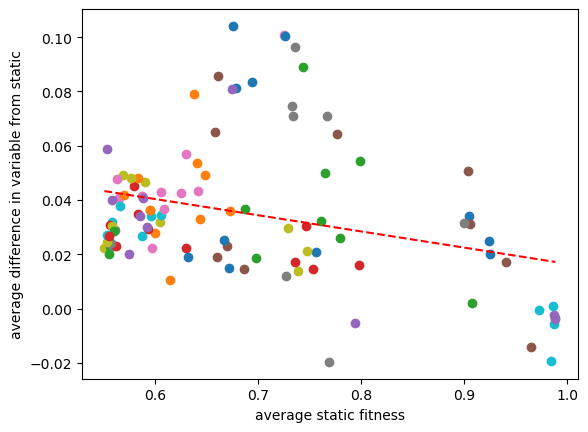

-0.30617412525567306 0.0014909280517472166


In [122]:
df['Group'] = df['Env'].apply(lambda x: 'vari' if 'vari' in x else ('stat' if 'stat' in x else 'other'))
dfnew=df#df[df["Seed"]==str(seed_intss[0])]
dfnew=dfnew.groupby(['CA', 'Seed','Group'])['Val'].mean().reset_index()
print(dfnew)
c=0
xs=[]
ys=[]
for s in seed_intss:
    for r in rules:
        x=dfnew[(dfnew["CA"]==str(r)) & (dfnew["Seed"]==str(s)) & (dfnew["Group"]=="stat")].Val.to_list()[0]
        #y=dfnew[(dfnew["CA"]==str(r)) & (dfnew["Group"]=="vari")].Val.to_list()[0]
        y=(avexs[c]+aveys[c])/2
        plt.scatter(x,y)
        xs.append(x)
        ys.append(y)
        c+=1
slope, intercept, r_value, p_value, std_err = linregress(xs, ys)
x_fit = np.linspace(min(xs), max(xs), 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, color='red', linestyle='--', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')
plt.ylabel("average difference in variable from static")
plt.xlabel("average static fitness")
plt.show()
print(r_value,p_value)

In [110]:
c

105

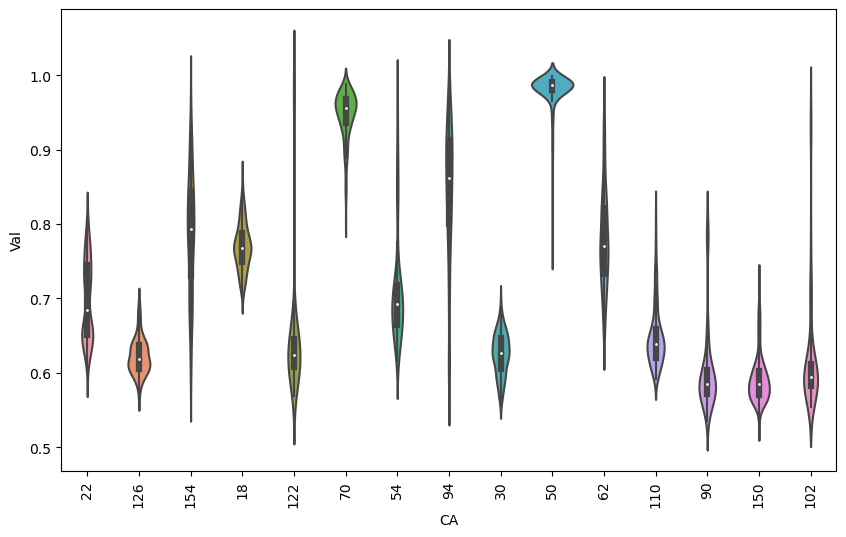

In [61]:
#temp_df = df[(df["Env"]=="static2") | (df["Env"]=="vari2")]
temp_df = df[(df["Env"]=="vari1") | (df["Env"]=="vari2")]
#temp_df = df[df['Seed'].isin([str(i) for i in seed_intss[1:]])]
fig, ax = plt.subplots(figsize=(10, 6))
#temp_df.boxplot(column='Val', by=['Env','CA'], ax=ax, grid=False)
sns.violinplot(data=temp_df,x="CA",y="Val")
plt.xticks(rotation=90)
plt.show()

In [62]:
data_groups=[]
for r in rules:
#for s in seed_intss:
    tl = temp_df[temp_df["CA"]==str(r)].Val.to_list()
    data_groups.append(tl)

#data_groups=[]
#for t in list(set(temp_df["Env"].to_list())):
    #tl = temp_df[temp_df["Env"]==str(t)].Val.to_list()
    #data_groups.append(tl)

In [63]:
data_groups

[[0.7643351699338146,
  0.7831851154738133,
  0.7991156582772158,
  0.7892248972920338,
  0.761983240119445,
  0.7366755135561032,
  0.8032663718555635,
  0.7736732453738548,
  0.76710450578583,
  0.7883226477767799,
  0.7637650155502879,
  0.7724692546703096,
  0.7764865757940342,
  0.7818985330100355,
  0.7783242701145787,
  0.7610303833617771,
  0.8065410453755972,
  0.7822063925410173,
  0.7954004535308143,
  0.7671202967975266,
  0.7678266446290408,
  0.7990210808690078,
  0.7790791345908589,
  0.7727332085259375,
  0.7705622846999036,
  0.7244693635450625,
  0.801588349728233,
  0.7642928011230137,
  0.7831225270099349,
  0.7830414739159715,
  0.714438337916539,
  0.6528581288292037,
  0.723530705774268,
  0.66100367052966,
  0.7322458618216977,
  0.6762773254722523,
  0.726272885993752,
  0.6659510258568109,
  0.722656447103058,
  0.6674619118010385,
  0.7235301566420085,
  0.6621244268955926,
  0.7295007181413983,
  0.6707404942033347,
  0.7014115128644591,
  0.6484490080970643

In [64]:
print("Shapiro-Wilk Test for Normality:")
for i, group in enumerate(data_groups, start=1):
    stat, p = shapiro(group)
    print(f"Group {i}: W={stat:.3f}, p={p:.3f}")
    if p > 0.05:
        print(f"  Group {i} follows a normal distribution (p > 0.05).")
    else:
        print(f"  Group {i} does not follow a normal distribution (p ≤ 0.05).")

print("\nLevene's Test for Homogeneity of Variances:")
stat, p = levene(*data_groups)
print(f"Levene's statistic={stat:.3f}, p={p:.3f}")
if p > 0.05:
    print("Variances are homogeneous (p > 0.05).")
else:
    print("Variances are not homogeneous (p ≤ 0.05).")


Shapiro-Wilk Test for Normality:
Group 1: W=0.921, p=0.000
  Group 1 does not follow a normal distribution (p ≤ 0.05).
Group 2: W=0.971, p=0.000
  Group 2 does not follow a normal distribution (p ≤ 0.05).
Group 3: W=0.984, p=0.020
  Group 3 does not follow a normal distribution (p ≤ 0.05).
Group 4: W=0.989, p=0.116
  Group 4 follows a normal distribution (p > 0.05).
Group 5: W=0.500, p=0.000
  Group 5 does not follow a normal distribution (p ≤ 0.05).
Group 6: W=0.868, p=0.000
  Group 6 does not follow a normal distribution (p ≤ 0.05).
Group 7: W=0.797, p=0.000
  Group 7 does not follow a normal distribution (p ≤ 0.05).
Group 8: W=0.915, p=0.000
  Group 8 does not follow a normal distribution (p ≤ 0.05).
Group 9: W=0.989, p=0.103
  Group 9 follows a normal distribution (p > 0.05).
Group 10: W=0.498, p=0.000
  Group 10 does not follow a normal distribution (p ≤ 0.05).
Group 11: W=0.978, p=0.002
  Group 11 does not follow a normal distribution (p ≤ 0.05).
Group 12: W=0.870, p=0.000
  Grou

In [65]:
stat, p = kruskal(*data_groups)
p

0.0

In [18]:
data = temp_df.copy()
data = data.rename(columns={"CA": "Factor_A", "Seed": "Factor_B", "Val":"Response"})

In [19]:
data["Mean_A"] = data.groupby("Factor_A")["Response"].transform("mean")
data["Mean_B"] = data.groupby("Factor_B")["Response"].transform("mean")
data["Mean_AB"] = data.groupby(["Factor_A", "Factor_B"])["Response"].transform("mean")
data["Grand_Mean"] = data["Response"].mean()

data["Aligned"] = data["Response"] - (data["Mean_A"] - data["Grand_Mean"]) \
                  - (data["Mean_B"] - data["Grand_Mean"]) \
                  - (data["Mean_AB"] - data["Grand_Mean"])

data["Ranked"] = rankdata(data["Aligned"])

model = ols("Ranked ~ Factor_A * Factor_B", data=data).fit()
anova_results = anova_lm(model, typ=2)  # Type-II ANOVA table
print("ART ANOVA Results:")
print(anova_results)


ART ANOVA Results:
                         sum_sq      df            F         PR(>F)
Factor_A           2.236329e+09    14.0  1704.876818   0.000000e+00
Factor_B           7.055756e+07     6.0   125.509790  3.473651e-142
Factor_A:Factor_B  1.246508e+07    84.0     1.583803   6.533715e-04
Residual           2.853002e+08  3045.0          NaN            NaN


In [20]:
 # Rank the data
data['rank'] = rankdata(data['Response'])

model = ols('rank ~ C(Factor_A) + C(Factor_B) + C(Factor_A):C(Factor_B)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                               sum_sq      df            F         PR(>F)
C(Factor_A)              2.059549e+09    14.0  1604.611142   0.000000e+00
C(Factor_B)              8.056390e+07     6.0   146.458652  1.313137e-163
C(Factor_A):C(Factor_B)  1.851226e+08    84.0    24.038417  3.088192e-272
Residual                 2.791654e+08  3045.0          NaN            NaN


In [21]:
formula = 'Val ~ C(Seed) + C(CA) + C(Seed):C(CA)'

# Fit the model
model = ols(formula, temp_df).fit()

# Perform ANOVA (parametric!)
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                  sum_sq      df            F         PR(>F)
C(Seed)         1.253032     6.0   135.865193  7.347082e-153
C(CA)          40.527015    14.0  1883.275683   0.000000e+00
C(Seed):C(CA)   3.187441    84.0    24.686538  5.037604e-279
Residual        4.680476  3045.0          NaN            NaN


In [106]:
root1="~/scratch/non_detailed_save/extra_inputs/"
root2="~/scratch/non_detailed_save/"
root3="~/scratch/detailed_save/"
season_len = 300
seed_intss = [[69904,149796],[4147842,1238860],[1677032,1410667],[2607162,1754028],[286634,159689],[2961036,153075],[3430997,2634107]]
metric = "maxfits"
num_reps = 15

maxxs = []
maxys = []
rules = [22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102]

print(len(rules))

max_pss=[]
for idx, seed_ints in enumerate(seed_intss):
    for rule in rules:
        if idx == 0:
            root=root3
        elif idx == 1:
            root=root2
        else:
            root=root1
        vari_maxs, env1_maxs, env2_maxs=helper.get_fits([rule,rule], seed_ints, metric, root, season_len, num_reps, id_start = 0)
        vari_maxs=[v[:9600] for v in vari_maxs]
        env1_maxs=[v[:9600] for v in env1_maxs]
        env2_maxs=[v[:9600] for v in env2_maxs]
        if metric == "geno_stds":
            vari_maxs=[v[9000:] for v in vari_maxs]
            env1_maxs=[v[9000:] for v in env1_maxs]
            env2_maxs=[v[9000:] for v in env2_maxs]
        d,c,ps,lists = helper.scatter_value(vari_maxs, env1_maxs, env2_maxs, season_len=300)
        max_pss.append(ps)
        maxxs.append(d[0])
        maxys.append(d[1])

15


/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  cset = contour_func(
/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befor

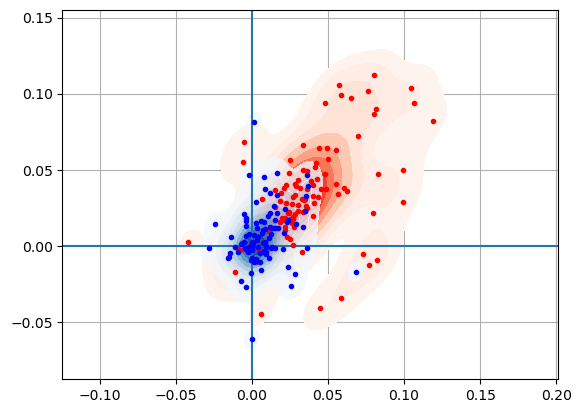

In [46]:
plt.plot(avexs,aveys,".",color="red",zorder=3)
sns.kdeplot(x=avexs, y=aveys, cmap="Reds", fill=True, thresh=0.05,zorder=2, edgecolor="black")
plt.plot(maxxs,maxys,".",color="blue",zorder=3)
sns.kdeplot(x=maxxs, y=maxys, cmap="Blues", fill=True, thresh=0.05,alpha=0.8,zorder=2)
#sns.kdeplot(x=maxxs, y=maxys, color="black", fill=False, thresh=0.1,alpha=0.8,zorder=3, lw=0.5)


plt.axis("equal")
plt.grid()
plt.axvline(0)
plt.axhline(0)

/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


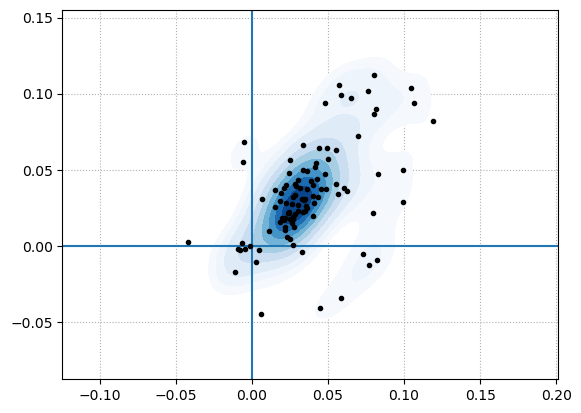

In [47]:
plt.plot(avexs,aveys,".",color="black",zorder=3)
sns.kdeplot(x=avexs, y=aveys, cmap="Blues", fill=True, thresh=0.1,zorder=2)
plt.axis("equal")
plt.grid(linestyle=":",zorder=-1)
plt.axvline(0)
plt.axhline(0)

In [ ]:
#variability keeps you away from narrow peaks . highest fitness peaks are narrow. variability does not necc help. 
# but it consistently find wider, which is somethies higher
# highest fit peak narrow. however there are wide basins that are higher than others and wihtou variability you are less likely to find them.
# without variability you get stuck in local optima. with variability you are pushed out of local optima. 
# with var can't get stuck in narrow local optime, but can get stuck in wide local optima. which can be worse or better (higher/lower than static) depending.

# In our environment the fitness has a max (1 when the patter is perfectly matched)
# Peaks near the max are narrow so robustness is not going to help you get there (see plot with max at the origin)
# However, during evolution, when you are not yet close to the max, mechanisms that promote robustness (here variability)
# can help you find better local optima (see plot with the avg leaning towards top-right)
# As such, the conundrum of "Can you have both evolvability and robustness" depends on the shape of landscape.
# i.e. There can be stages where you have your cake and eat it too.

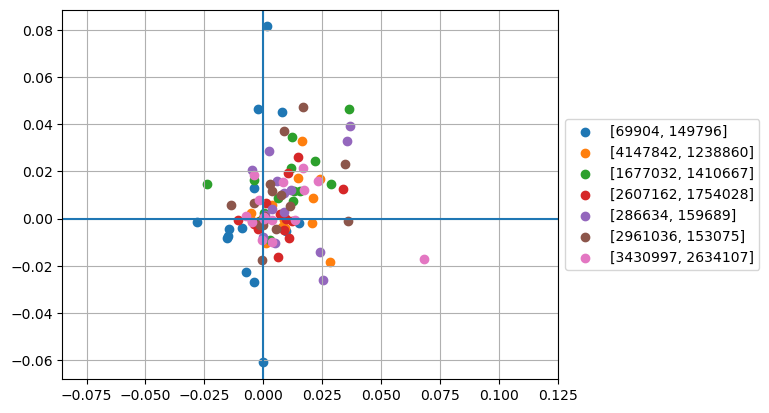

In [50]:
n=len(rules)
for i in range(len(seed_intss)):
    plt.scatter(maxxs[n*i:n*(i+1)],maxys[n*i:n*(i+1)],label=seed_intss[i])
    #for j, label in enumerate(rules):
        #plt.text(xs[n*i:n*(i+1)][j], ys[n*i:n*(i+1)][j], label, fontsize=12)
#plt.scatter(xs[:len(rules)],ys[:len(rules)],c="red")
#plt.scatter(xs[len(rules):],ys[len(rules):],c="blue")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axis("equal")
plt.grid()
plt.axvline(0)
plt.axhline(0)

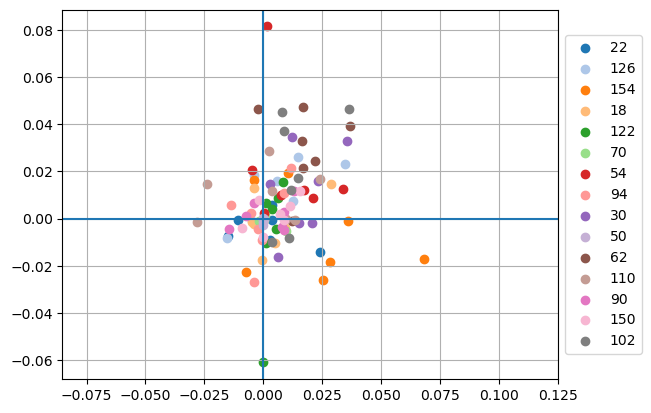

In [51]:
colors = sns.color_palette("tab20", len(rules))
n=len(rules)
for i in range(n):
    #plt.scatter(maxxs[n*i:n*(i+1)],maxys[n*i:n*(i+1)],label=seed_intss[i])
    plt.scatter(maxxs[i::n],maxys[i::n],label=rules[i],color=colors[i])
    #for j, label in enumerate(rules):
        #plt.text(xs[n*i:n*(i+1)][j], ys[n*i:n*(i+1)][j], label, fontsize=12)
#plt.scatter(xs[:len(rules)],ys[:len(rules)],c="red")
#plt.scatter(xs[len(rules):],ys[len(rules):],c="blue")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axis("equal")
plt.grid()
plt.axvline(0)
plt.axhline(0)

In [104]:
max_pss[0][0]

array([0.84710733, 0.86685148, 0.83885423, 0.84710744, 0.84278478,
       0.84705492, 0.84297484, 0.83057851, 0.85330579, 0.84090909,
       0.86156694, 0.84297521, 0.86363611, 0.83264463, 0.85950413])

Text(0, 0.5, 'Variable - static envrionment 2 fitnesses')

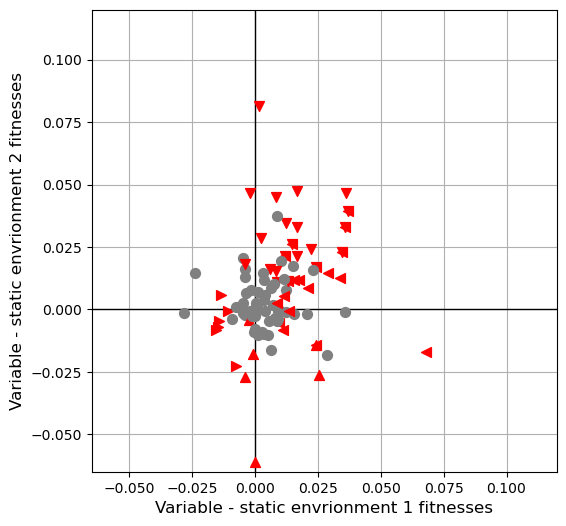

In [107]:
fig = plt.figure(figsize=(6,6))
plt.axvline(0,lw=1, color="black",zorder=1)
plt.axhline(0,lw=1, color="black",zorder=1)

mysize=50
myalpha=1
c=0
for i in range(len(seed_intss)):
        for rule in rules:
                if max_pss[c][0] >= 0.05 and max_pss[c][1] >= 0.05:
                        mycolor = "grey"
                        mymarker = "o"
                        plt.scatter(maxxs[c],maxys[c],marker=mymarker,color=mycolor,alpha=myalpha,s=mysize,zorder=2)
                else:
                        if max_pss[c][0] < 0.05:
                                if maxxs[c] > 0:
                                        plt.scatter(maxxs[c],maxys[c],marker="<",color="red",alpha=myalpha,s=mysize,zorder=2)
                                        #plt.text(maxxs[c],maxys[c],rule)
                                else:
                                        plt.scatter(maxxs[c],maxys[c],marker=">",color="red",alpha=myalpha,s=mysize,zorder=2)
                                        #plt.text(maxxs[c],maxys[c],rule)
                        if max_pss[c][1] < 0.05:
                                if maxys[c] > 0:
                                        plt.scatter(maxxs[c],maxys[c],marker="v",color="red",alpha=myalpha,s=mysize,zorder=2)
                                        #plt.text(maxxs[c],maxys[c],rule)
                                else:
                                        plt.scatter(maxxs[c],maxys[c],marker="^",color="red",alpha=myalpha,s=mysize,zorder=2)
                                        #plt.text(maxxs[c],maxys[c],rule)

                
                #plt.text(maxxs[c],maxys[c],rule)

                c+=1

plt.grid()
plt.gca().set_axisbelow(True)
#plt.axis("equal")
plt.ylim(-0.065, 0.12)
plt.xlim(-0.065, 0.12)
plt.xlabel("Variable - static envrionment 1 fitnesses",fontsize=12)
plt.ylabel("Variable - static envrionment 2 fitnesses",fontsize=12)

Text(0, 0.5, 'Variable - static envrionment 2 fitnesses')

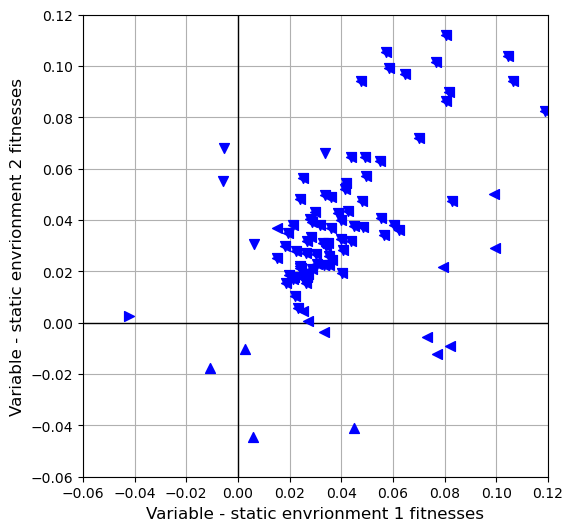

In [86]:
fig = plt.figure(figsize=(6,6))
plt.axvline(0,lw=1, color="black",zorder=1)
plt.axhline(0,lw=1, color="black",zorder=1)
mysize=50
myalpha=1
c=0
for i in range(len(seed_intss)):
        for rule in rules:
                if ave_pss[c][0] < 0.05:
                        if avexs[c] > 0:
                                plt.scatter(avexs[c],aveys[c],marker="<",color="blue",alpha=myalpha,s=mysize,zorder=2)
                                #plt.text(maxxs[c],maxys[c],rule)
                        else:
                                plt.scatter(avexs[c],aveys[c],marker=">",color="blue",alpha=myalpha,s=mysize,zorder=2)
                                #plt.text(maxxs[c],maxys[c],rule)
                if ave_pss[c][1] < 0.05:
                        if aveys[c] > 0:
                                plt.scatter(avexs[c],aveys[c],marker="v",color="blue",alpha=myalpha,s=mysize,zorder=2)
                                #plt.text(maxxs[c],maxys[c],rule)
                        else:
                                plt.scatter(avexs[c],aveys[c],marker="^",color="blue",alpha=myalpha,s=mysize,zorder=2)
                                #plt.text(maxxs[c],maxys[c],rule)

                c+=1

plt.grid()
plt.gca().set_axisbelow(True)
#plt.axis("equal")
plt.ylim(-0.065, 0.12)
plt.xlim(-0.065, 0.12)
plt.xlabel("Variable - static envrionment 1 fitnesses",fontsize=12)
plt.ylabel("Variable - static envrionment 2 fitnesses",fontsize=12)

/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

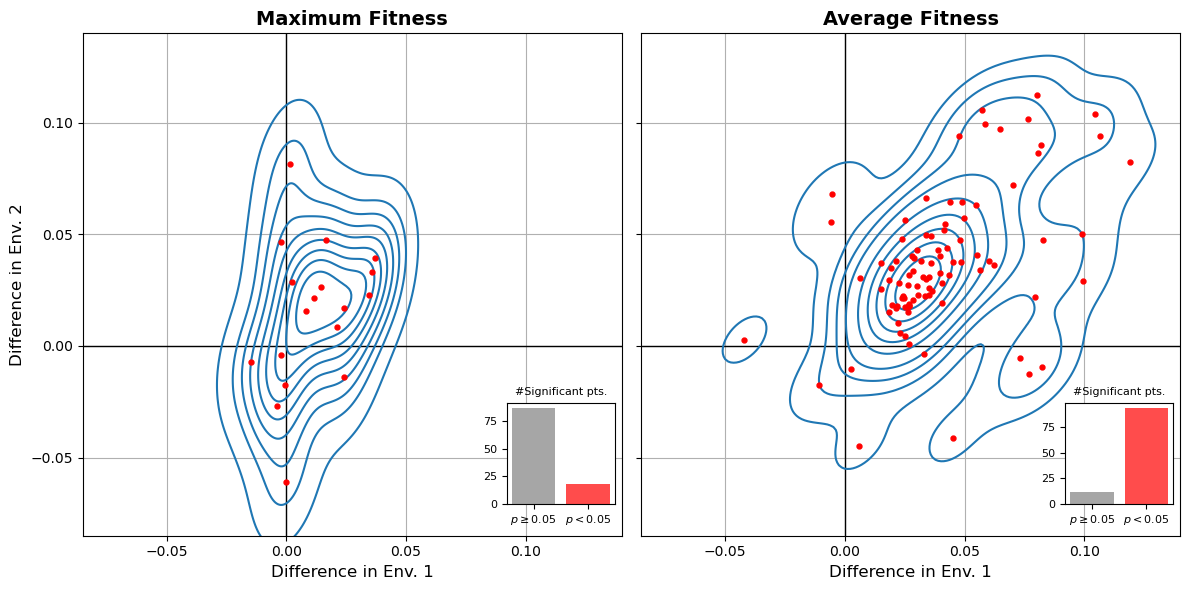

In [128]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#plt.style.use('seaborn-v0_8-dark')

# Main figure and subplots
fig, [ax0, ax1] = plt.subplots(figsize=(12, 6), ncols=2, sharex=True, sharey=True)

# Add lines to subplots
for ax in [ax0, ax1]:
    ax.axvline(0, lw=1, color="black", zorder=1, alpha=1)
    ax.axhline(0, lw=1, color="black", zorder=1, alpha=1)

# Example unzip function
def unzip(l):
    return list(zip(*l))

alpha_sig = 0.05
max_adjusted_pvalues = multipletests(np.array(max_pss).flatten(), method='fdr_bh')[1]
max_adjusted_pvalues = max_adjusted_pvalues.reshape(105,2)
ave_adjusted_pvalues = multipletests(np.array(ave_pss).flatten(), method='fdr_bh')[1]
ave_adjusted_pvalues = ave_adjusted_pvalues.reshape(105,2)

kwargs = {"color":"red", "alpha":1, "s":50, "zorder":2}

max_sig_xs, max_sig_ys = unzip([(x,y) for (env1, env2),x,y in zip(max_adjusted_pvalues, maxxs, maxys) if env1 < alpha_sig or env2 < alpha_sig])
sns.kdeplot(x = max_sig_xs, y = max_sig_ys, ax=ax0,fill=False)
for (env1, env2),x,y in zip(max_adjusted_pvalues, maxxs, maxys):
        cwargs = dict(kwargs)
        if env1 < alpha_sig or env2 < alpha_sig:
                ax0.scatter(x,y,marker=".", **cwargs)

ave_sig_xs, ave_sig_ys = unzip([(x,y) for (env1, env2),x,y in zip(ave_adjusted_pvalues, avexs, aveys) if env1 < alpha_sig or env2 < alpha_sig])
sns.kdeplot(x = ave_sig_xs, y = ave_sig_ys, ax=ax1,fill=False)
for (env1, env2),x,y in zip(ave_adjusted_pvalues, avexs, aveys):
        cwargs = dict(kwargs)
        if env1 < alpha_sig or env2 < alpha_sig:
                ax1.scatter(x,y,marker=".", **cwargs)

# Set axis properties
for ax in [ax0, ax1]:
    ax.grid()
    ax.set_axisbelow(True)

# Add inset bar plots
nsig_max = len(max_sig_xs)
nsig_ave = len(ave_sig_xs)
tot = len(maxxs)
inset_data_max = [tot - nsig_max, nsig_max]  # Made-up data for max plot
inset_data_avg = [tot - nsig_ave, nsig_ave]  # Made-up data for average plot
categories = [f'$p \geq {alpha_sig}$', f'$p < {alpha_sig}$']
sig_colors = ["gray", "red"]

ax0.set_ylim(-0.085, 0.14)
ax0.set_xlim(-0.085, 0.14)
ax1.set_ylim(-0.085, 0.14)
ax1.set_xlim(-0.085, 0.14)

# Inset for ax0
inset_ax0 = inset_axes(ax0, 
                       width="100%", 
                       height="100%", 
                       loc='lower right', 
                       bbox_to_anchor=[0.8, 0.05, 0.2, 0.2], 
                       bbox_transform=ax0.transAxes)
inset_ax0.bar(categories, inset_data_max, color=sig_colors, alpha=0.7)
inset_ax0.set_title("#Significant pts.", fontsize=8)
inset_ax0.tick_params(axis='both', which='major', labelsize=8)

# Inset for ax1
#inset_ax1 = inset_axes(ax1, width="20%", height="20%", loc='upper left')
inset_ax1 = inset_axes(ax1, 
                       width="100%", 
                       height="100%", 
                       loc='lower right', 
                       bbox_to_anchor=[0.8, 0.05, 0.2, 0.2], 
                       bbox_transform=ax1.transAxes)
inset_ax1.bar(categories, inset_data_avg, color=sig_colors, alpha=0.7)
inset_ax1.set_title("#Significant pts.", fontsize=8)
inset_ax1.tick_params(axis='both', which='major', labelsize=8)

# Axis labels and titles
ax0.set_xlabel("Difference in Env. 1", fontsize=12)
ax0.set_ylabel("Difference in Env. 2", fontsize=12)
ax1.set_xlabel("Difference in Env. 1", fontsize=12)
ax0.set_title("Maximum Fitness", weight="bold", fontsize=14)
ax1.set_title("Average Fitness", weight="bold", fontsize=14)

# Adjust layout and show plot
plt.subplots_adjust(wspace=0.05, hspace=0.3)
plt.tight_layout()
plt.show()
plt.style.use('default')


In [123]:
print(np.array(ave_pss).shape)
adjusted_pvalues = multipletests(np.array(ave_pss).flatten(), method='holm')[1]
c=0
for a in adjusted_pvalues.reshape(105,2):
    if a[0] < 0.05 or a[1] < 0.05:
        c+=1

(105, 2)


In [124]:
c

72

In [201]:
matplotlib.__version__

'3.8.0'

In [165]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


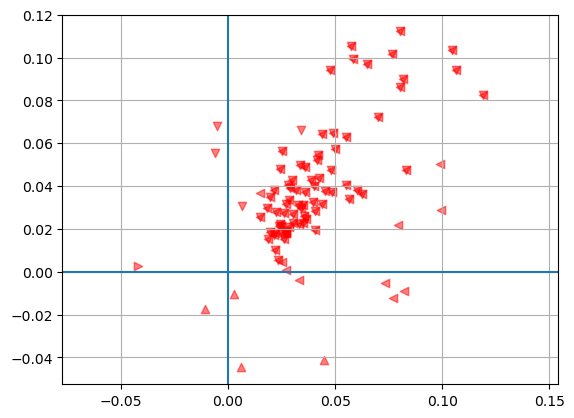

In [54]:
plt.axis("equal")
plt.grid()
plt.axvline(0)
plt.axhline(0)
c=0
for i in range(len(seed_intss)):
        for rule in rules:
                if ave_pss[c][0] < 0.05:
                        if avexs[c] > 0:
                                plt.scatter(avexs[c],aveys[c],marker="<",color="red",alpha=0.5)
                                #plt.text(avexs[c],aveys[c],rule)

                        else:
                                plt.scatter(avexs[c],aveys[c],marker=">",color="red",alpha=0.5)
                                #plt.text(avexs[c],aveys[c],rule)
                if ave_pss[c][1] < 0.05:
                        if aveys[c] > 0:
                                plt.scatter(avexs[c],aveys[c],marker="v",color="red",alpha=0.5)
                                #plt.text(avexs[c],aveys[c],rule)
                        else:
                                plt.scatter(avexs[c],aveys[c],marker="^",color="red",alpha=0.5)
                                #plt.text(avexs[c],aveys[c],rule)

                c+=1

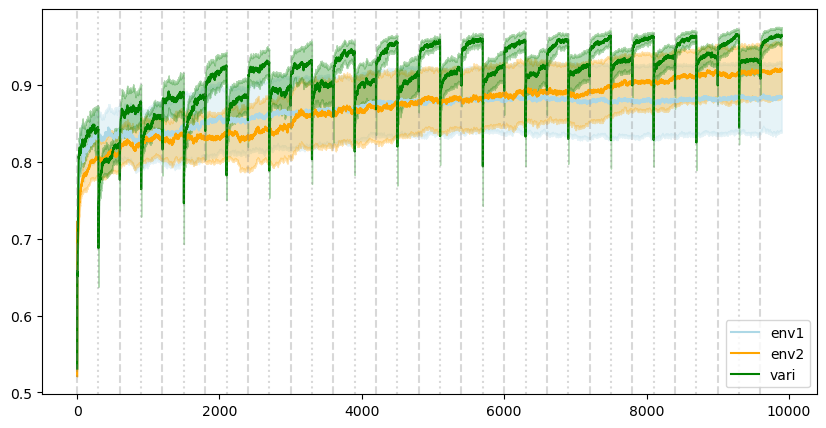

In [11]:
seed_intss = [[69904,149796],[4147842,1238860],[1677032,1410667],[2607162,1754028],[286634,159689],[2961036,153075],[3430997,2634107]]
metric="avefits"
season_len = 300
num_reps=15
root="~/scratch/detailed_save/"
id_start=0
seed_ints = seed_intss[0]
rule = 70
all_maxs=helper.get_fits([rule,rule], seed_ints, metric, root, season_len, num_reps, id_start, extrapolate=True)
all_maxs=np.array(all_maxs)
labels=["vari","env1","env2"]
colors = ["green", "lightblue", "orange"]
z_value = 1.96  # For a 95% confidence interval

#print(np.array(vari_maxs).shape)

#plot all variable, together
fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(10, 5),sharex=True) #sharey=True)
for i,m in enumerate(all_maxs[1:]):
    mean1 = np.mean(m, axis=0)
    stderr1 = np.std(m, axis=0) / np.sqrt(num_reps)
    ci_upper = mean1 + z_value * stderr1
    ci_lower = mean1 - z_value * stderr1
    ax.fill_between(range(len(mean1)), ci_lower, ci_upper, alpha=0.3, color = colors[1:][i])
    ax.plot(mean1, "-", label=labels[1:][i], color = colors[1:][i])
m=all_maxs[0]
mean1 = np.mean(m, axis=0)
stderr1 = np.std(m, axis=0) / np.sqrt(num_reps)
ci_upper = mean1 + z_value * stderr1
ci_lower = mean1 - z_value * stderr1
ax.fill_between(range(len(mean1)), ci_lower, ci_upper, alpha=0.3,color=colors[0])
ax.plot(mean1, "-", label= labels[0], color=colors[0])
#ax.set_xlim(1000,1700)
ax.legend()
for j in range(0, len(mean1), season_len):
    if j % (season_len * 2) == 0:
        ax.axvline(j, linestyle="--", color="gray", alpha=0.3)
    else:
        ax.axvline(j, linestyle=":", color="gray", alpha=0.3)

In [79]:
#root="~/Documents/GitHub/CA_GRN2/results_new_rules/"
#root="~/Documents/GitHub/CA_GRN2/results_testing_saving/"
root="~/scratch/non_detailed_save/"
#root="~/scratch/old_save/"
season_len = 300
seed_ints = [69904,149796] #[4147842,1238860]###
metric = "maxfits"
num_reps = 3

# NOTE: CAN USE BELOW CODE WITH THE FOLLOWING: 
# avail_metrics = ["avefits","maxfits","beststd","spec_pheno_stds", "pheno_stds", "geno_stds"]
# beststd - how good it could get at biased phenotypic variation, max
# spec_pheno_stds - how good it could get at biased phenotypic variation, mean
# pheno_stds - pheno variation among kids of one parent

#NOTE: I HAVE DECIDED THAT IT IS WEIRD TO END WITH SEASON 1 and have that season be seen more than season 2. 
# So cutting off end to be 9600 ends with season 2, all 300 gens (double checked)

xs = []
ys = []
#rules=np.array([22, 126, 146, 154, 82, 86, 18, 118, 122, 70,54,94,30,50,62,110,90,150,102,254])
#rules=np.array([22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102])
rules=np.arange(0,256)

#Excluded 82 == 154, 146 == 18, 86 == 30, 118 == 62, 254 conceptually == 50
print(len(rules))
stds_mask = []
for rule in rules:
    #print(rule)
    vari_maxs, env1_maxs, env2_maxs=helper.get_fits([rule,rule], seed_ints, metric, root, season_len, num_reps, id_start = 0)
    vari_maxs=[v[:9600] for v in vari_maxs]
    env1_maxs=[v[:9600] for v in env1_maxs]
    env2_maxs=[v[:9600] for v in env2_maxs]
    if metric == "geno_stds":
        vari_maxs=[v[9000:] for v in vari_maxs]
        env1_maxs=[v[9000:] for v in env1_maxs]
        env2_maxs=[v[9000:] for v in env2_maxs]
    d,c,stds = helper.scatter_value(vari_maxs, env1_maxs, env2_maxs, season_len=300)
    xs.append(c[0])
    ys.append(c[1])

256


In [3]:
'''
for i, rule in enumerate(rules):
    if rule in stds_mask and rule %2==0: #and ys[i] > -0.01: # the few patterns ys[i] > -0.01 not representative of very simple patterns
        #if label not in [38,134,198]: #not representative of very simple patterns
            plt.scatter(xs[i],ys[i],color="red")
            plt.text(xs[i], ys[i], rule, fontsize=12, color = "black")
'''

'\nfor i, rule in enumerate(rules):\n    if rule in stds_mask and rule %2==0: #and ys[i] > -0.01: # the few patterns ys[i] > -0.01 not representative of very simple patterns\n        #if label not in [38,134,198]: #not representative of very simple patterns\n            plt.scatter(xs[i],ys[i],color="red")\n            plt.text(xs[i], ys[i], rule, fontsize=12, color = "black")\n'

In [80]:
root="~/scratch/detailed_save/"
#root="~/scratch/old_save/"
season_len = 300
seed_ints = [69904,149796] #[4147842,1238860]###
metric = "maxfits"
num_reps = 15
orirules=np.array([22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102])

orixs=[]
oriys=[]
for rule in orirules:
    #print(rule)
    vari_maxs, env1_maxs, env2_maxs=helper.get_fits([rule,rule], seed_ints, metric, root, season_len, num_reps, id_start = 0)
    vari_maxs=[v[:9600] for v in vari_maxs]
    env1_maxs=[v[:9600] for v in env1_maxs]
    env2_maxs=[v[:9600] for v in env2_maxs]
    if metric == "geno_stds":
        vari_maxs=[v[9000:] for v in vari_maxs]
        env1_maxs=[v[9000:] for v in env1_maxs]
        env2_maxs=[v[9000:] for v in env2_maxs]
    d,c,stds = helper.scatter_value(vari_maxs, env1_maxs, env2_maxs, season_len=300)
    orixs.append(c[0])
    oriys.append(c[1])

/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(-0.8, 0.5)

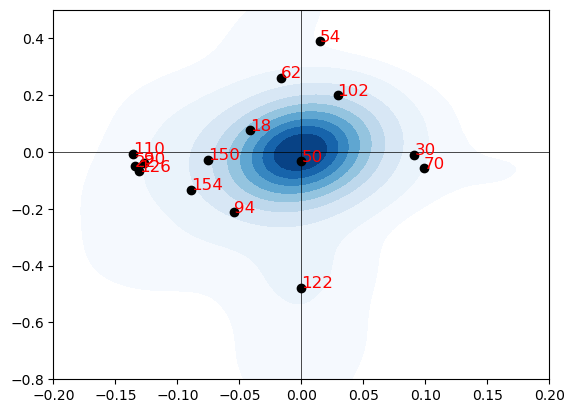

In [82]:
usefulxs = []
usefulys = []
for i, rule in enumerate(rules):
    if rule %2 == 0: #only check even rules, 000 -> 1
        usefulxs.append(xs[i])
        usefulys.append(ys[i])

sns.kdeplot(x=usefulxs, y=usefulys, cmap="Blues", fill=True, thresh=0.1)

for i, label in enumerate(orirules):
    plt.text(orixs[i], oriys[i], label, fontsize=12, color = "red")

plt.scatter(orixs, oriys, color = "black")

plt.axvline(0, lw=0.5, color="black")
plt.axhline(0, lw=0.5, color="black")
plt.xlim(-0.2,0.2)
plt.ylim(-0.8,0.5)

In [70]:
root="~/scratch/detailed_save/"
#root="~/scratch/old_save/"
season_len = 300
seed_ints = [69904,149796] #[4147842,1238860] ###
metric = "avefits"
num_reps = 15
orirules=np.array([22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102])

newxs=[]
newys=[]
vari_ave=[]
for rule in orirules:
    #print(rule)
    vari_maxs, env1_maxs, env2_maxs=helper.get_fits([rule,rule], seed_ints, metric, root, season_len, num_reps, id_start = 0)
    vari_maxs=[v[:9600] for v in vari_maxs]
    env1_maxs=[v[:9600] for v in env1_maxs]
    env2_maxs=[v[:9600] for v in env2_maxs]
    if metric == "geno_stds":
        vari_maxs=[v[9000:] for v in vari_maxs]
        env1_maxs=[v[9000:] for v in env1_maxs]
        env2_maxs=[v[9000:] for v in env2_maxs]
    d,c,stds = helper.scatter_value(vari_maxs, env1_maxs, env2_maxs, season_len=300)
    newxs.append(c[0])
    newys.append(c[1])
    vari_ave.append((c[0]+c[1])/2)

seed_ints = [4147842,1238860] ###
root="~/scratch/non_detailed_save/"
for rule in orirules:
    #print(rule)
    vari_maxs, env1_maxs, env2_maxs=helper.get_fits([rule,rule], seed_ints, metric, root, season_len, num_reps, id_start = 0)
    vari_maxs=[v[:9600] for v in vari_maxs]
    env1_maxs=[v[:9600] for v in env1_maxs]
    env2_maxs=[v[:9600] for v in env2_maxs]
    if metric == "geno_stds":
        vari_maxs=[v[9000:] for v in vari_maxs]
        env1_maxs=[v[9000:] for v in env1_maxs]
        env2_maxs=[v[9000:] for v in env2_maxs]
    d,c,stds = helper.scatter_value(vari_maxs, env1_maxs, env2_maxs, season_len=300)
    newxs.append(c[0])
    newys.append(c[1])
    vari_ave.append((c[0]+c[1])/2)



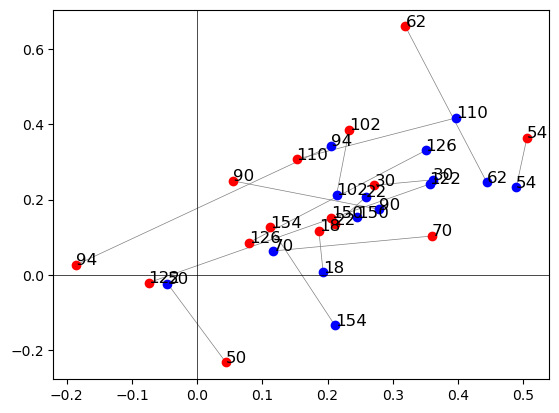

In [71]:
#plt.scatter(xs, ys, color="blue")
plt.scatter(newxs[:15], newys[:15], color="red")
plt.scatter(newxs[15:], newys[15:], color="blue")
for i, label in enumerate(orirules):
    plt.text(newxs[i], newys[i], label, fontsize=12, color = "black")
for i, label in enumerate(orirules):
    plt.text(newxs[i+15], newys[i+15], label, fontsize=12, color = "black")
for x0, x1, y0, y1 in zip(newxs[:15],newxs[15:], newys[:15], newys[15:]):
    plt.plot([x0,x1],[y0,y1],lw=0.5, color="gray",zorder=-1)
plt.axvline(0, lw=0.5, color="black")
plt.axhline(0, lw=0.5, color="black")

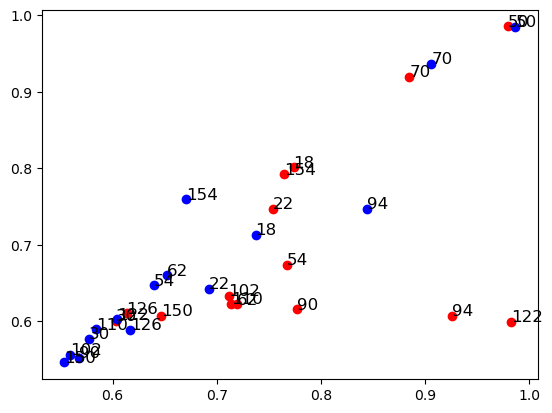

In [72]:
root="~/scratch/detailed_save/"
seed_ints = [69904,149796] #[4147842,1238860] ###
metric = "avefits"
id_start = 0

env1_end=[]
env2_end=[]
state_ave=[]
for rule in orirules:
    all_maxs=helper.get_fits([rule,rule], seed_ints, metric, root, season_len, num_reps, id_start, extrapolate=True)
    #vari_end = np.array(all_maxs[0])[:,-1].mean()
    env1_end.append(np.array(all_maxs[1])[:,-1].mean())
    env2_end.append(np.array(all_maxs[2])[:,-1].mean())
    state_ave.append((env1_end[-1]+env2_end[-1])/2)

root="~/scratch/non_detailed_save/"
seed_ints = [4147842,1238860] ###
for rule in orirules:
    all_maxs=helper.get_fits([rule,rule], seed_ints, metric, root, season_len, num_reps, id_start, extrapolate=True)
    #vari_end = np.array(all_maxs[0])[:,-1].mean()
    env1_end.append(np.array(all_maxs[1])[:,-1].mean())
    env2_end.append(np.array(all_maxs[2])[:,-1].mean())
    state_ave.append((env1_end[-1]+env2_end[-1])/2)

plt.scatter(env1_end[:15], env2_end[:15], color="red")
plt.scatter(env1_end[15:], env2_end[15:], color="blue")
for i, label in enumerate(orirules):
    plt.text(env1_end[i], env2_end[i], label, fontsize=12, color = "black")
for i, label in enumerate(orirules):
    plt.text(env1_end[i+15], env2_end[i+15], label, fontsize=12, color = "black")
    

0.3299984080945668


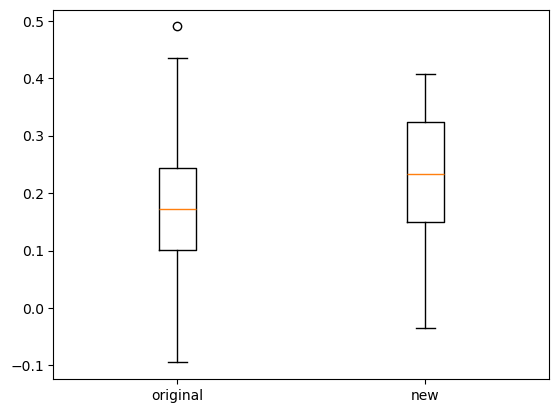

In [73]:
plt.boxplot([vari_ave[:15],vari_ave[15:]],labels=["original","new"])
t_stat, p_value = stats.ttest_ind(vari_ave[:15], vari_ave[15:])
print(p_value)

Text(0.69, 0.48, '$r$ = -0.57, $p$ = 0.000991488769543768')

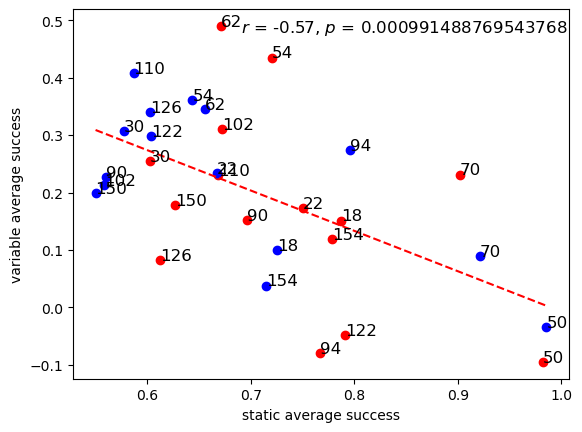

In [78]:
plt.scatter(state_ave[:15], vari_ave[:15], color="red")
plt.scatter(state_ave[15:], vari_ave[15:], color="blue")
for i, label in enumerate(orirules):
    plt.text(state_ave[i], vari_ave[i], label, fontsize=12, color = "black")
for i, label in enumerate(orirules):
    plt.text(state_ave[i+15], vari_ave[i+15], label, fontsize=12, color = "black")

x=state_ave
y=vari_ave
plt.xlabel("static average success")
plt.ylabel("variable average success")
slope, intercept, r_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, color='red', linestyle='--', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')
plt.text(0.69, 0.48, f'$r$ = {r_value:.2f}, $p$ = {p_value}',fontsize=12)

In [4]:
#Plotting targets
nrows = len(rules)
ncols = 2
scale=2
dev_steps=22
num_cells=22

plotting = False

counter=0
rcounter=0
targets=[]
for i in range(nrows*2):
    if counter % 2 == 0:
        start_pattern = helper.seedID2string(seed_ints[0], num_cells)
        target = helper.rule2targets_wrapped_wstart(int(rules[rcounter]), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
        targets.append(target)
    else:
        start_pattern = helper.seedID2string(seed_ints[1], num_cells)
        target = helper.rule2targets_wrapped_wstart(int(rules[rcounter]), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
        rcounter+=1
        targets.append(target)
    counter+=1

#----------------
if plotting:
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * scale, nrows*scale), sharex=True, sharey=True)
    #ax.set_title(f"Rule: {rules[i]}", fontsize=16)

    axs = axs.flatten()
    counter=0
    rcounter=0
    targets=[]
    for i, ax in enumerate(axs):
        if counter % 2 == 0:
            start_pattern = helper.seedID2string(seed_ints[0], num_cells)
            target = helper.rule2targets_wrapped_wstart(int(rules[rcounter]), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
            #print("one",rules[rcounter])
            ax.set_ylabel(rules[rcounter], rotation=90, size='large')
            targets.append(target)
        else:
            start_pattern = helper.seedID2string(seed_ints[1], num_cells)
            target = helper.rule2targets_wrapped_wstart(int(rules[rcounter]), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
            #print("two",rules[rcounter])
            rcounter+=1
            targets.append(target)
        helper.imshow_ca(target,ax=ax)
        counter+=1

    for ax, col in zip(axs, ["T1","T2"]):
        ax.set_title(col)

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_1599/2939256344.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1599/2939256344.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


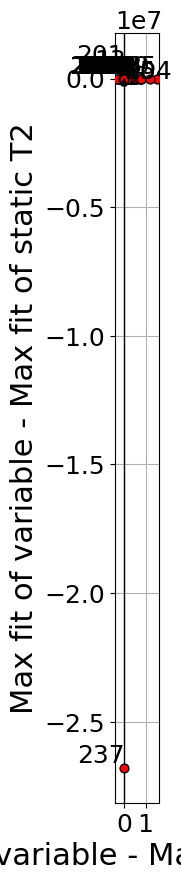

In [6]:
Ts = [
    targets[0::2],
    targets[1::2],
]

#xs,ys=pickle.load(open("2env_scatter.p", "rb"))

#rules_ims=[102,54,62,50,254,30,90,150,94,110]
#rules_scatter=[54,94,30,50,62,110,90,150,102,254]

plt.rcParams["font.size"] = 18

fig = plt.figure(constrained_layout=True, figsize=(18,10))
gs = fig.add_gridspec(len(rules), len(rules), wspace=0.0, hspace=0.2)
ax = fig.add_subplot(gs[:, :8])

helper.main_plt(xs, ys, rules, ax)

for T in [0, 1]:
    for i in range(len(rules)):
        ax = fig.add_subplot(gs[i, 8 + T])
        if i == 0 and T == 0:
            ax.set_title(f"T{T+1}", ha="center")
        if i == 0 and T == 1:
            ax.set_title(f"          T{T+1}   Rule", ha="center")
        if T == 1:
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(f" {rules[i]}", rotation="horizontal", ha="left")
        helper.imshow_ca(Ts[T][i], ax=ax)

plt.tight_layout()
plt.show()
#plt.savefig("figs/2envinp_scatter.png")

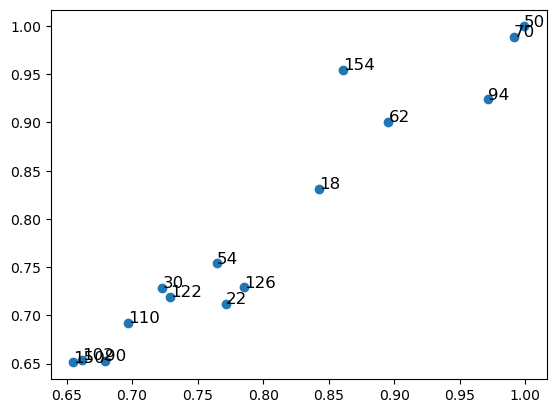

In [38]:
metric = "maxfits"
id_start = 0
env1_end=[]
env2_end=[]
for rule in rules:
    all_maxs=helper.get_fits([rule,rule], seed_ints, metric, root, season_len, num_reps, id_start, extrapolate=True)
    #vari_end = np.array(all_maxs[0])[:,-1].mean()
    env1_end.append(np.array(all_maxs[1])[:,-1].mean())
    env2_end.append(np.array(all_maxs[2])[:,-1].mean())

plt.scatter(env1_end, env2_end)
for i, label in enumerate(rules):
    plt.text(env1_end[i], env2_end[i], label, fontsize=12)
#plt.xlim(0.7,1)
#plt.ylim(0.7,1)


In [ ]:
root="~/scratch/non_detailed_save/"
#root="~/scratch/old_save/"
season_len = 300
seed_ints = [4147842,1238860]
num_reps=5
metric = "maxfits"
id_start = 0
env1_end=[]
env2_end=[]
for rule in rules:
    all_maxs=helper.get_fits([rule,rule], seed_ints, metric, root, season_len, num_reps, id_start, extrapolate=True)
    #vari_end = np.array(all_maxs[0])[:,-1].mean()
    env1_end.append(np.array(all_maxs[1])[:,-1].mean())
    env2_end.append(np.array(all_maxs[2])[:,-1].mean())

plt.scatter(env1_end, env2_end)
for i, label in enumerate(rules):
    plt.text(env1_end[i], env2_end[i], label, fontsize=12)

root="~/scratch/detailed_save/"
#root="~/scratch/old_save/"
season_len = 300
seed_ints = [69904,149796]
num_reps=15
metric = "maxfits"
id_start = 0
env1_end2=[]
env2_end2=[]
for rule in rules:
    all_maxs=helper.get_fits([rule,rule], seed_ints, metric, root, season_len, num_reps, id_start, extrapolate=True)
    #vari_end = np.array(all_maxs[0])[:,-1].mean()
    env1_end.append(np.array(all_maxs[1])[:,-1].mean())
    env2_end.append(np.array(all_maxs[2])[:,-1].mean())

plt.scatter(env1_end, env2_end)
for i, label in enumerate(rules):
    plt.text(env1_end[i], env2_end[i], label, fontsize=12)

In [33]:
rules

array([ 22, 126, 154,  18, 122,  70,  54,  94,  30,  50,  62, 110,  90,
       150, 102])

In [34]:
rules2 = [22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102]
rules == rules2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

22
[6297 8090 9295 4495 3284 4492 5073 6874 3848 4490 5980  899 7463 9289
 9292]


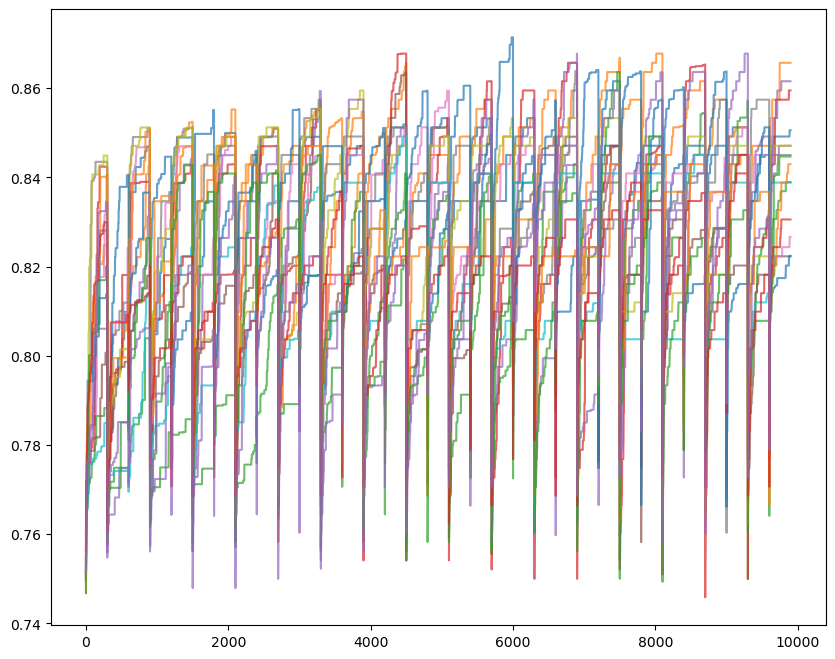

126
[5699 6296 6850 3861  885 8071 8093 6289 9294 2054 3872 9890 5685 9897
 7485]


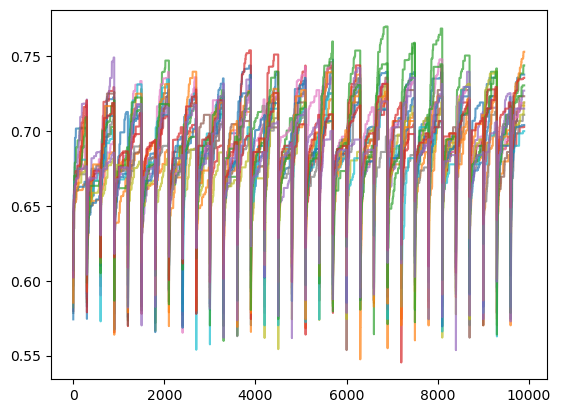

154
[9587 8991 6595 1186 2963 9592 5904 1191 5994 8985 5399 4194 5395 5395
 7149]


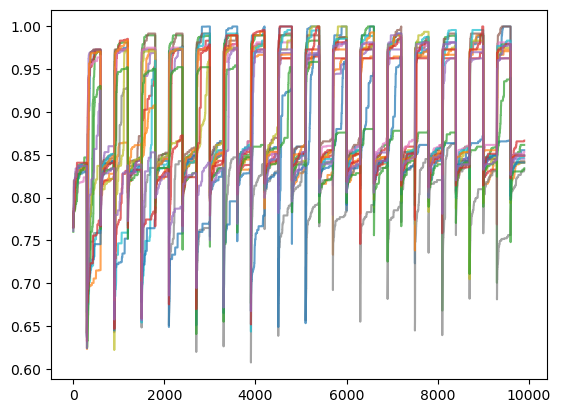

18
[4731 7783 4189 4751 9588 3584 9590 9596 4795 4759 7793 7198 9596 7744
 9599]


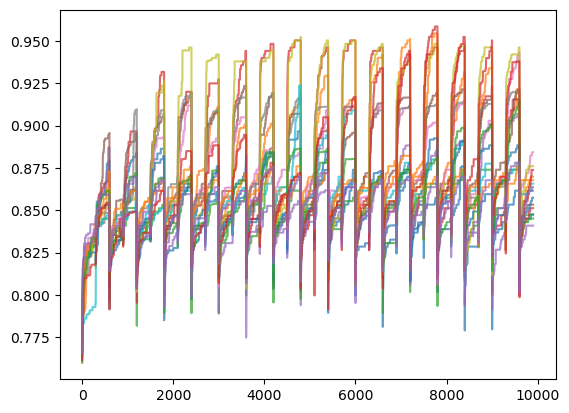

122
[1211 9208 1323 9786  873 2640 1280 8099 9874 9726 1344  868 1396  851
 5699]


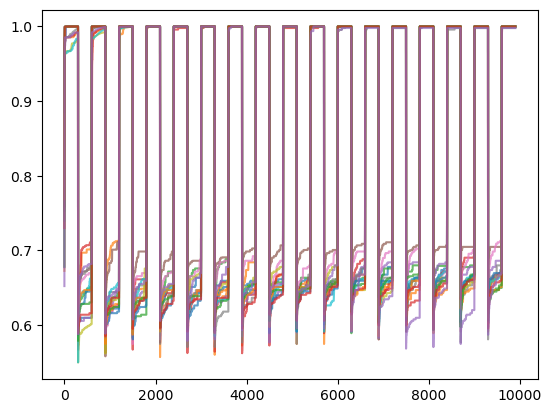

70
[4213 4181 8355 1566  908 1504 2609 4657 9045 2319 1883 1195 8274 2503
 1255]


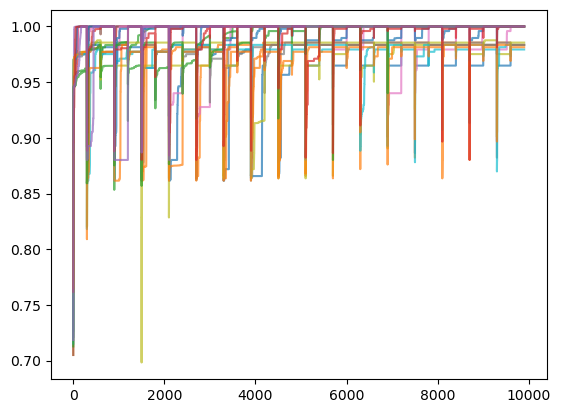

54
[9894 7496 9897 9898 9272 9877 6297 4500 8698 8098 7500 9898 9399 6884
 9289]


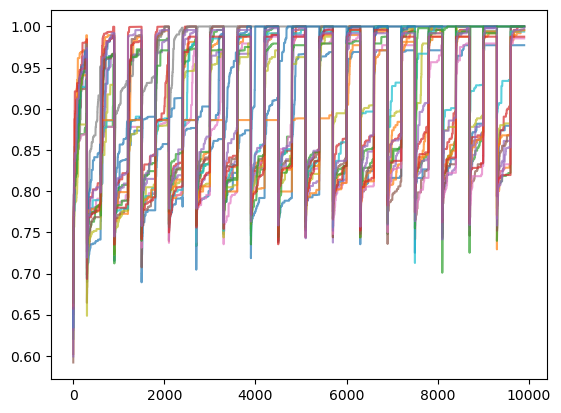

94
[3299 9887  881 8098 8513  290 9674 7449 2098 3899 5422 4497 8060 8071
 7399]


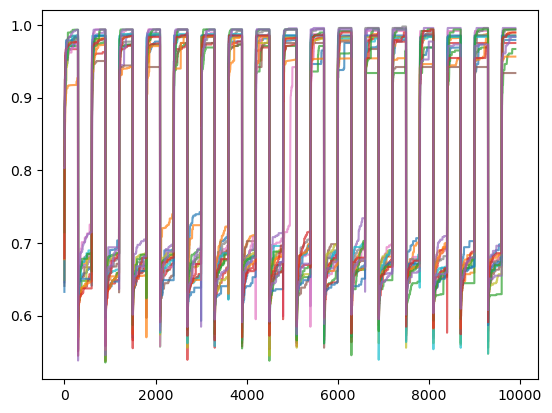

30
[8098 6890 9268 5314 8056 9276 5691 9849 9756 9896 6291 3298 8089 3892
 5685]


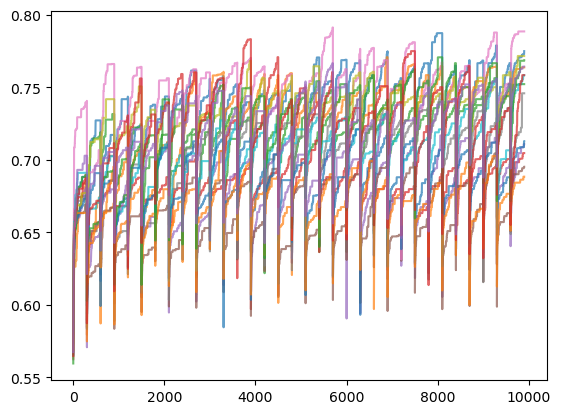

50
[ 697 8341  719 9610  700  800  900 8002 6953 9000  903 7464  587  813
  695]


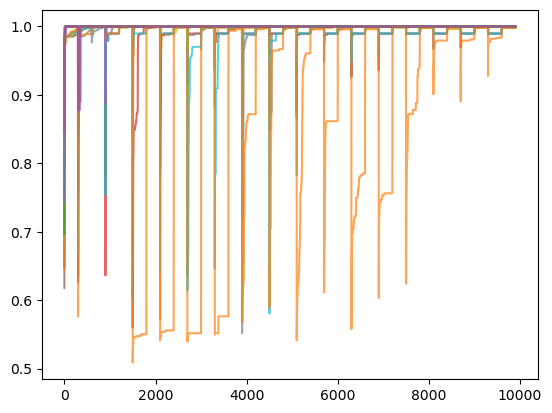

62
[9278 8667 6293 4482 1477 2691 7498 3881 3269 9864 3285 5659 4493 8988
 9247]


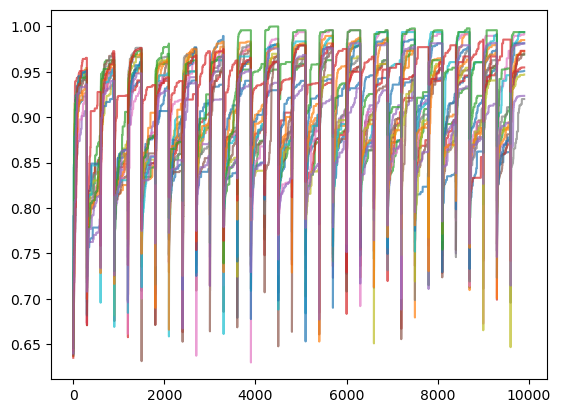

110
[1128 4167 9890 8392  807  290 4499 3206 9894 6249 5086 6863 3829 6594
 7068]


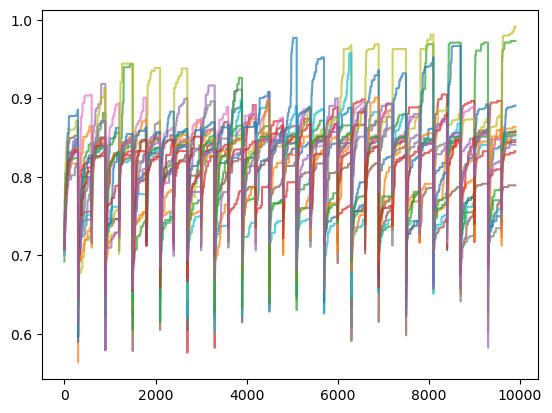

90
[9263 1475 6279 8097 9835 9265 9270 6894 7478 8679 8698 5670 8097 6296
 7481]


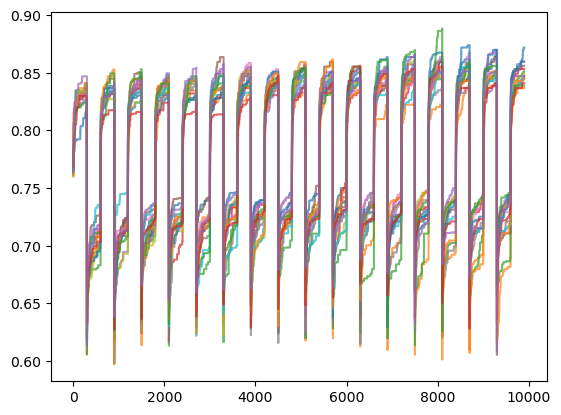

150
[9806 3244  876 6888 9845 9238 3293  883 6283 7492 5084 6862 6276  278
 9245]


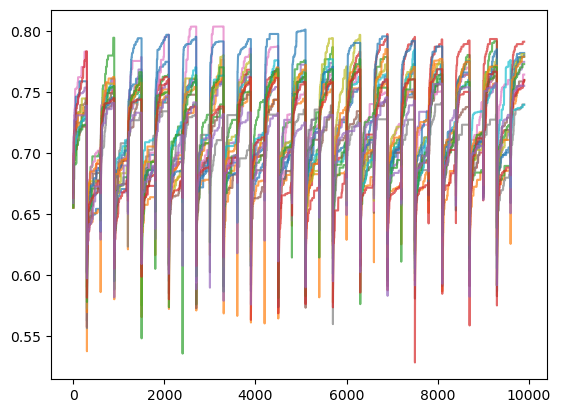

102
[5483 8058 2100 8099 9547 9773 9573 9583 8099 6352 8098 5376 4171 9830
 8962]


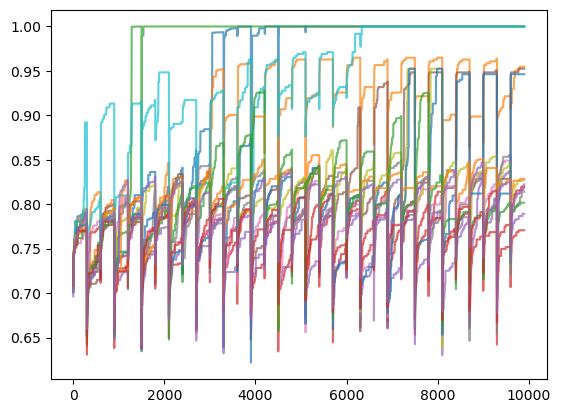

In [6]:
#102: no success env 2, 1 success env 1, 3 full success vari, another 4 close

root="~/scratch/detailed_save/"
temprules = [70]
#metric = "spec_pheno_stds"
#metric = "pheno_stds"
metric = "maxfits"
num_reps = 15
season_len=300
id_start = 0
seed_ints = [69904,149796]
#149796

rules = [22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102]

maxs=[]
fig = plt.figure(figsize=(10,8))
for rule in rules:
    print(rule)
    vari_maxs=[np.loadtxt(os.path.expanduser(root+f"variable/stats_{season_len}_{rule}-{rule}_69904-149796_{i+1+id_start}_{metric}.txt")) for i in range(num_reps)]
    #vari_maxs=[np.loadtxt(os.path.expanduser(root+f"static/stats_{season_len}_{rule}_{149796}_{i+1+id_start}_{metric}.txt")) for i in range(num_reps)]
    vari_maxs=[v[:9899] for v in vari_maxs]
    print(np.argmax(vari_maxs, axis = 1))
    for i, v in enumerate(vari_maxs):
        #print(i)
        plt.plot(v,label=i, alpha = 0.7)
        #plt.show()
    #print(np.array(vari_maxs).shape)
    #plt.plot(np.array(vari_maxs).mean(axis=0),label=i, alpha = 0.7)
    #maxs.append(np.array(vari_maxs).mean(axis=0)[-1])
    #plt.legend()
    #plt.xlim(0,300)
    plt.show()

In [38]:
print(maxs)

[0.8419417070927072, 0.7132473393348688, 0.9903762915173657, 0.8934772282770693, 0.7331140132680428, 0.9970616811236872, 0.8159153898599029, 0.7120286610623949, 0.7279448462160018, 0.9999999999999998, 0.8618669243827536, 0.8416067586683113, 0.738241371359846, 0.7205135024001457, 0.8172591238446502]


In [20]:
metric, rule

('maxfits', 70)

(15, 9899)


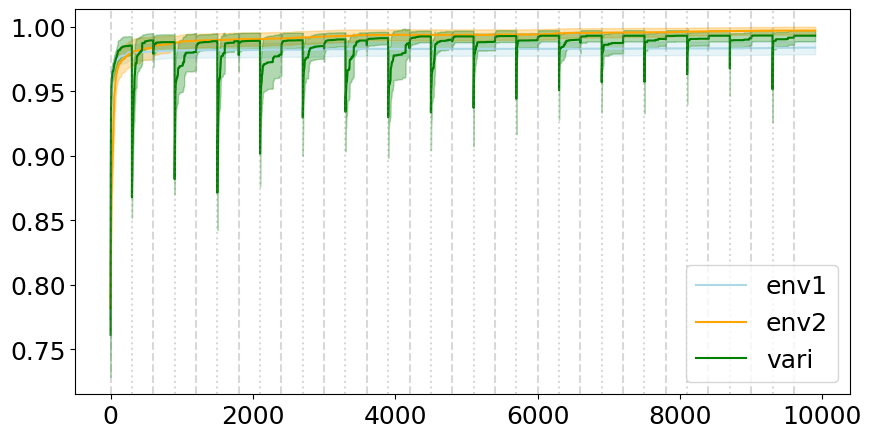

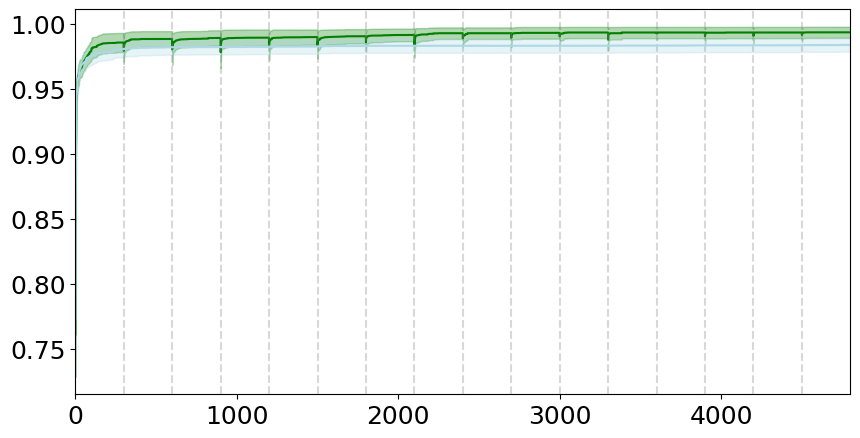

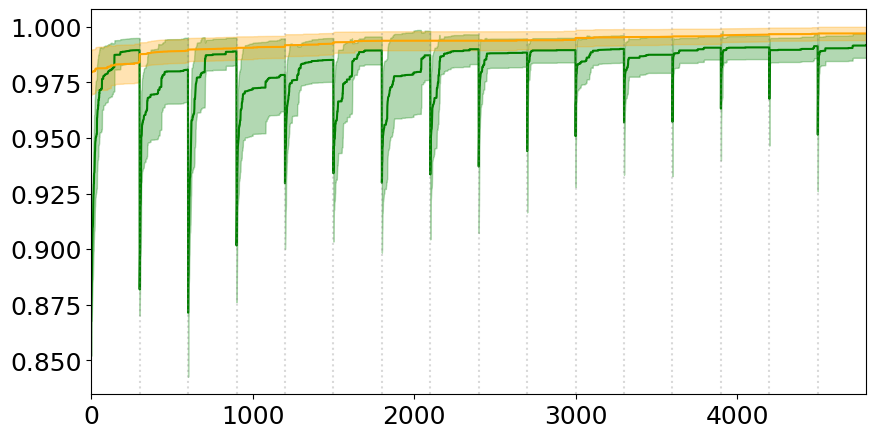

In [21]:
all_maxs=helper.get_fits([rule,rule], seed_ints, metric, root, season_len, num_reps, id_start, extrapolate=True)
all_maxs=np.array(all_maxs)
labels=["vari","env1","env2"]
colors = ["green", "lightblue", "orange"]
z_value = 1.96  # For a 95% confidence interval

print(np.array(vari_maxs).shape)

#plot all variable, together
fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(10, 5),sharex=True) #sharey=True)
for i,m in enumerate(all_maxs[1:]):
    mean1 = np.mean(m, axis=0)
    stderr1 = np.std(m, axis=0) / np.sqrt(num_reps)
    ci_upper = mean1 + z_value * stderr1
    ci_lower = mean1 - z_value * stderr1
    ax.fill_between(range(len(mean1)), ci_lower, ci_upper, alpha=0.3, color = colors[1:][i])
    ax.plot(mean1, "-", label=labels[1:][i], color = colors[1:][i])
m=vari_maxs #all_maxs[0]
mean1 = np.mean(m, axis=0)
stderr1 = np.std(m, axis=0) / np.sqrt(num_reps)
ci_upper = mean1 + z_value * stderr1
ci_lower = mean1 - z_value * stderr1
ax.fill_between(range(len(mean1)), ci_lower, ci_upper, alpha=0.3,color=colors[0])
ax.plot(mean1, "-", label= labels[0], color=colors[0])
#ax.set_xlim(1000,1700)
ax.legend()
for j in range(0, len(mean1), season_len):
    if j % (season_len * 2) == 0:
        ax.axvline(j, linestyle="--", color="gray", alpha=0.3)
    else:
        ax.axvline(j, linestyle=":", color="gray", alpha=0.3)

'''
#put together with color
season1, season2, gens1, gens2 = helper.chunker_plotting(mean1, season_len = 300)
season1_std, season2_std, _, _ = helper.chunker_plotting(stderr1, season_len = 300)
fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(10, 5),sharex=True) #sharey=True)
for i in range(len(gens1)):
    ax.plot(gens1[i], season1[i],color="C1")
    ax.fill_between(gens1[i], season1[i] - season1_std[i], season1[i] + season1_std[i], alpha=0.3,color="C1")
    ax.plot(gens2[i], season2[i],color="C2")
    ax.fill_between(gens2[i], season2[i] - season2_std[i], season2[i] + season2_std[i], alpha=0.3,color="C2")
for j in range(0, len(mean1), season_len):
    if j % (season_len * 2) == 0:
        ax.axvline(j, linestyle="--", color="gray", alpha=0.3)
    else:
        ax.axvline(j, linestyle=":", color="gray", alpha=0.3)
plt.show()
'''

#chunk it up!
season1, season2, chunked_gens1, chunked_gens2 = helper.chunker_plotting(mean1, season_len = 300)
season1 = np.reshape(season1, (season1.shape[0]*season1.shape[1]))
season2 = np.reshape(season2, (season2.shape[0]*season2.shape[1]))

season1_std, season2_std, _, _ = helper.chunker_plotting(stderr1, season_len = 300)
season1_std = np.reshape(season1_std, (season1_std.shape[0]*season1_std.shape[1]))
season2_std = np.reshape(season2_std, (season2_std.shape[0]*season2_std.shape[1]))

#chunk the statics too
chunked_gens1 = np.array([x for xs in chunked_gens1 for x in xs])
chunked_gens2 = np.array([x for xs in chunked_gens2 for x in xs])

fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(10, 5),sharex=True) #sharey=True)
ax.plot(season1,color=colors[0])
ax.fill_between(range(len(season1)), season1 - z_value*season1_std, season1 + z_value*season1_std, alpha=0.3,color=colors[0])
for j in range(0, len(season1), season_len):
    if j % (season_len * 2) == 0:
        ax.axvline(j, linestyle="--", color="gray", alpha=0.3)
    else:
        ax.axvline(j, linestyle="--", color="gray", alpha=0.3)
mean1 = np.mean(all_maxs[1][:, chunked_gens1], axis=0) #all reps, only chunked gens
stderr1 = np.std(all_maxs[1][:, chunked_gens1], axis=0) / np.sqrt(num_reps)
ci_upper = mean1 + z_value * stderr1
ci_lower = mean1 - z_value * stderr1
ax.fill_between(range(len(mean1)), ci_lower, ci_upper, alpha=0.3, color = colors[1])
ax.plot(mean1, "-", label=labels[1], color = colors[1])
plt.xlim(0, len(season1))
#plt.ylim(0.8,0.9)
plt.show()

fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(10, 5),sharex=True) #sharey=True)
ax.plot(season2,color=colors[0])
ax.fill_between(range(len(season2)), season2 - z_value*season2_std, season2 + z_value*season2_std, alpha=0.3,color=colors[0])
for j in range(0, len(season2), season_len):
    if j % (season_len * 2) == 0:
        ax.axvline(j, linestyle=":", color="gray", alpha=0.3)
    else:
        ax.axvline(j, linestyle=":", color="gray", alpha=0.3)
mean1 = np.mean(all_maxs[2][:, chunked_gens2], axis=0)
stderr1 = np.std(all_maxs[2][:, chunked_gens2], axis=0) / np.sqrt(num_reps)
ci_upper = mean1 + z_value * stderr1
ci_lower = mean1 - z_value * stderr1
ax.fill_between(range(len(mean1)), ci_lower, ci_upper, alpha=0.3, color = colors[2])
ax.plot(mean1, "-", label=labels[2], color = colors[2])
plt.xlim(0, len(season1))
#plt.ylim(0.9,1)
plt.show()

In [21]:
root = "~/Documents/GitHub/CA_GRN2/results_testing_saving/"
avail_metrics = ["avefits","maxfits","beststd","spec_pheno_stds", "pheno_stds","geno_stds"]
metric = avail_metrics[5]
rules = [rule,rule]
output=[np.loadtxt(os.path.expanduser(root+f"stats_{season_len}_{rules[0]}-{rules[1]}_{seed_ints[0]}-{seed_ints[1]}_{i+1}_{metric}.txt")) for i in range(1)]

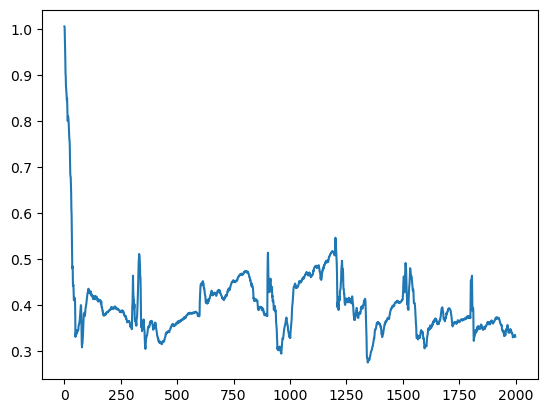

In [22]:
plt.plot(output[0])